Edward Murphy  
Predictive Modeling - Data Science  
Final Project  
5/8/19  

# Objectives:
1. Perform PCA unsupervised learning to uncover which features explain most of the variance and reduce the feature space.
2. Model ppi which is a quantatative performance measurement for the school.
3. Model accountability_level which is a qualatative performance measurement for the school.

In [2]:
%matplotlib inline

import sys
print('python version:')
print(sys.version)

import warnings
warnings.filterwarnings("ignore")

from tools.tools import load_python_data, min_max_scaler, label_encoder, get_top_abs_correlations, best_subset_selection, print_tree
from tools.statsmodels import diagnostic_plots, regression_plots_2d
from schools_dict import df_dict

import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.formula.api as smf
import statsmodels.api as sm

import graphviz
import pydotplus
from IPython.display import Image 

python version:
3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
dependent_variables = ['ppi', 'accountability_level']
qualatatives = ['accountability_level']
quantatatives = ['ppi', 'total_enroll', 'first_language_not_english_p', 'english_language_learner_p',
                'students_with_disabilities_p', 'high_needs_p', 'economically_disadvantaged_p',
                'african_american_p', 'asian_p', 'hispanic_p', 'white_p', 'native_american_p',
                'hawaiian_p', 'multi_race_p', 'males_p', 'females_p', 'total_classes', 'avg_class_size',
                'num_students', 'avg_salary', 'total_expend', 'avg_expend_per_pupil']

# Load Data

In [4]:
# dataset from https://www.kaggle.com/ndalziel/massachusetts-public-schools-data
df = load_python_data('ma_schools_2017', df_dict)

# set index to school_code for easy identification
if not df.school_code.is_unique:
    raise Exception('Expected school_code to be unique to use as index')

df = df.set_index(df.school_code)
df = df.drop(['school_code'], axis=1)
df.head()

,school_name,school_type,town,total_enroll,first_language_not_english_p,english_language_learner_p,students_with_disabilities_p,high_needs_p,economically_disadvantaged_p,african_american_p,asian_p,hispanic_p,white_p,native_american_p,hawaiian_p,multi_race_p,males_p,females_p,total_classes,avg_class_size,num_students,avg_salary,total_expend,avg_expend_per_pupil,accountability_level,ppi
school_code,,,,,,,,,,,,,,,,,,,,,,,,,,
00010505,Abington High,Public School,Abington,452.0,5.3,2.4,9.7,28.8,21.5,2.2,1.5,9.1,85.8,0.2,0.2,0.9,45.6,54.4,204.0,15.8,451.0,74662.0,27229100.8,13270.84,Level 1,76.0
00010003,Beaver Brook Elementary School,Public School,Abington,580.0,10.5,7.2,13.3,37.1,23.3,1.9,1.9,6.7,88.4,0.5,0.2,0.3,50.2,49.8,325.0,24.6,643.0,74662.0,27229100.8,13270.84,Level 3,69.0
00010002,Center Elementary School,Public School,Abington,203.0,12.8,3.0,21.2,34.0,16.3,3.9,3.0,8.4,84.7,0.0,0.0,0.0,54.2,45.8,112.0,14.6,208.0,74662.0,27229100.8,13270.84,Insufficient data,NaN
00010405,Frolio Middle School,Public School,Abington,328.0,5.5,1.8,13.1,30.8,21.6,2.4,1.8,6.1,89.3,0.0,0.0,0.3,53.4,46.6,218.0,21.1,342.0,74662.0,27229100.8,13270.84,Level 2,63.0
00010015,Woodsdale Elementary School,Public School,Abington,353.0,5.9,2.0,10.8,30.6,22.7,2.0,1.4,4.2,92.1,0.0,0.0,0.3,50.7,49.3,121.0,30.4,334.0,74662.0,27229100.8,13270.84,Level 2,65.0


## Data Preprocessing

In [5]:
# clean numerical variables
print('length before dropping null values:', len(df))
df = df.dropna()
print('length after dropping null values:', len(df))

# clean qualatative variables: accountability_level, school_type, town, school_name
# interestingly, school_type is "Public School" for all observations at this step so I am removing the feature.
# also school_name and town are is good for reference but should not be included in analysis because
# they are nearly unique per observation.
df = df.drop(['school_type', 'school_name', 'town'], axis=1)
df = df[df.accountability_level != 'Insufficient data']
print('length after cleaning qualatative variables:', len(df))

# encode qualatative variables and standardize quantatative variables
df, le_dict = label_encoder(df, qualatatives)
df = min_max_scaler(df, quantatatives)

length before dropping null values: 1861
length after dropping null values: 1519
length after cleaning qualatative variables: 1518


## Dimensionality Reduction

To start, I will manually inspect the distributions of the numerical variables and remove any that are mostly 0.

In [6]:
df.describe()

,total_enroll,first_language_not_english_p,english_language_learner_p,students_with_disabilities_p,high_needs_p,economically_disadvantaged_p,african_american_p,asian_p,hispanic_p,white_p,native_american_p,hawaiian_p,multi_race_p,males_p,females_p,total_classes,avg_class_size,num_students,avg_salary,total_expend,avg_expend_per_pupil,accountability_level,ppi
count,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000
mean,0.124503,0.182398,0.118708,0.151297,0.370077,0.325561,0.101276,0.085126,0.184911,0.638563,0.031370,0.021846,0.207794,0.373745,0.630241,0.129442,0.407159,0.122941,0.557793,0.135996,0.235313,0.882740,0.619371
std,0.085184,0.198838,0.163114,0.079564,0.255570,0.242101,0.156440,0.120385,0.225505,0.288048,0.064395,0.053473,0.135023,0.062783,0.063167,0.106515,0.097285,0.083916,0.132680,0.244841,0.140633,0.757789,0.222094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072602,0.031000,0.011307,0.110317,0.162386,0.122381,0.019608,0.017639,0.040041,0.449246,0.000000,0.000000,0.114943,0.339744,0.603226,0.055848,0.349112,0.071454,0.465083,0.025016,0.148361,0.000000,0.465753
50%,0.102788,0.098000,0.043970,0.140960,0.297374,0.261852,0.041830,0.039349,0.078029,0.749749,0.000000,0.000000,0.183908,0.369391,0.634677,0.098143,0.411243,0.102893,0.549024,0.044690,0.187312,1.000000,0.602740
75%,0.146503,0.274500,0.164573,0.176456,0.559361,0.481257,0.101961,0.098711,0.242556,0.869347,0.042254,0.023256,0.270115,0.400641,0.664516,0.170055,0.472633,0.147865,0.624925,0.112677,0.276355,1.000000,0.780822
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
# remove features that have mostly 0 values
df = df.drop(['native_american_p', 'hawaiian_p'], axis=1)
# remove features that I believe will complicate interpretation
df = df.drop(['multi_race_p'], axis=1)

Top absolute valued correlations:

males_p                       females_p                      -0.999972
total_enroll                  num_students                    0.995096
high_needs_p                  economically_disadvantaged_p    0.966597
total_classes                 num_students                    0.882247
first_language_not_english_p  english_language_learner_p      0.881610
total_enroll                  total_classes                   0.880642
first_language_not_english_p  white_p                        -0.858863
hispanic_p                    white_p                        -0.842932
high_needs_p                  white_p                        -0.836546
                              hispanic_p                      0.811411
first_language_not_english_p  hispanic_p                      0.787735
economically_disadvantaged_p  hispanic_p                      0.785508
english_language_learner_p    white_p                        -0.782932
                              high_needs_p

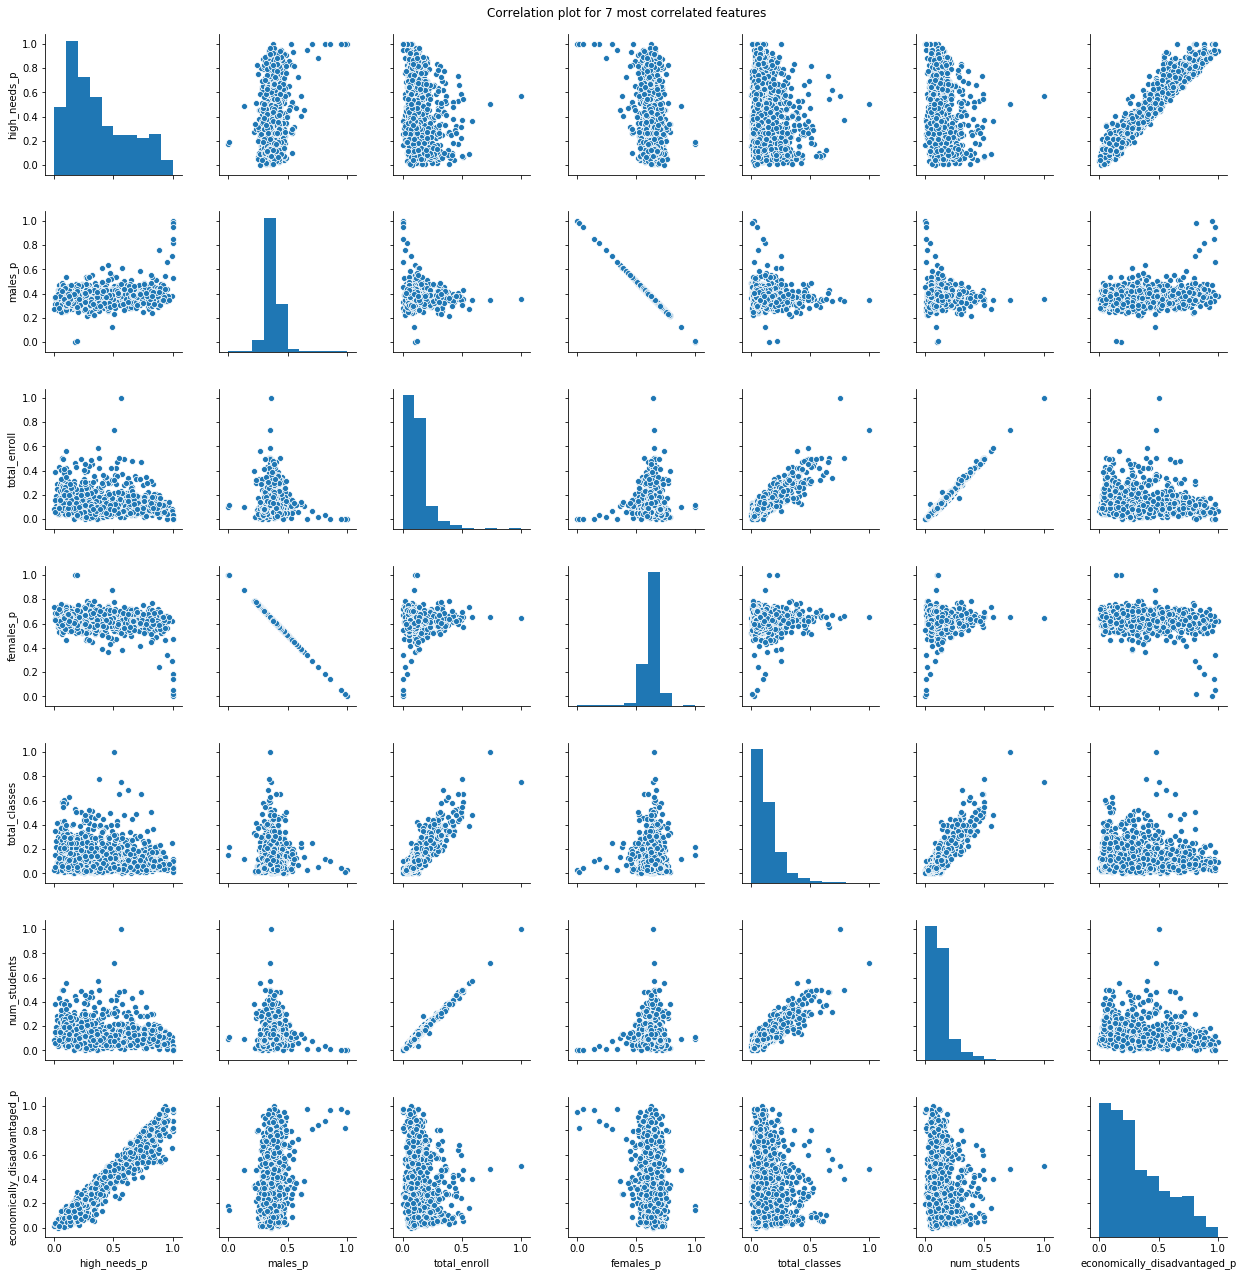

In [8]:
# consolidate features with absolute correlation greater than 0.7
corr_df, correlated = get_top_abs_correlations(df, 0.7, 7)
features_to_remove = ['males_p', 'total_enroll', 'economically_disadvantaged_p', 'total_classes',
                      'first_language_not_english_p', 'hispanic_p', 'high_needs_p', 'english_language_learner_p']
print('Top absolute valued correlations:\n')
print(corr_df)
g = sns.pairplot(df[correlated])
g.fig.suptitle('Correlation plot for 7 most correlated features', y=1.01)
df = df.drop(columns=features_to_remove, axis=1)
g

In [8]:
print('num features after dimensionality reduction:', len(df.columns) - len(dependent_variables))
print('\npreprocessed data:\n')
df.head()

num features after dimensionality reduction: 10

preprocessed data:



,students_with_disabilities_p,african_american_p,asian_p,white_p,females_p,avg_class_size,num_students,avg_salary,total_expend,avg_expend_per_pupil,accountability_level,ppi
school_code,,,,,,,,,,,,
00010505,0.077630,0.028758,0.020353,0.857286,0.725806,0.322485,0.095660,0.564268,0.020044,0.142793,0,0.671233
00010003,0.114402,0.024837,0.025780,0.883417,0.651613,0.582840,0.140457,0.564268,0.020044,0.142793,2,0.575342
00010405,0.112360,0.031373,0.024423,0.892462,0.600000,0.479290,0.070229,0.564268,0.020044,0.142793,1,0.493151
00010015,0.088866,0.026144,0.018996,0.920603,0.643548,0.754438,0.068362,0.564268,0.020044,0.142793,1,0.520548
00030025,0.124617,0.009150,0.002714,0.927638,0.603226,0.449704,0.120625,0.401200,0.010557,0.072627,1,0.643836


## Unsupervised Learning: PCA

As the below output indicates the features that explain most of the variance in the feature space are:
- african_american_p
- white_p
- total_expend

In [9]:
# Dropping the dependent variables "ppi" and "accountability_level"
# because my goal for using PCA here is to analyze the feature space.
df_for_pca = df.drop(dependent_variables, axis=1)
pca = PCA()
pca.fit_transform(df_for_pca)
PCs = pca.explained_variance_ratio_
print('PCs:\n', PCs)

PCs = PCs[np.where(PCs > 0.5)]
num_PCs = len(PCs)
print('\nPCs that explain more than 50% variance:\n', PCs)

# only 1 PC
coeffs = abs( pca.components_[0] )
print('\ncofficients for best PC:\n', coeffs)

f = lambda x: x > 0.3
best_coeffs = np.array([f(xi) for xi in coeffs])
features_from_pca = np.array(df_for_pca.columns)[best_coeffs]
print('\nbest features from PCA:\n', features_from_pca)

PCs:
 [0.57030929 0.11871187 0.08387193 0.06767705 0.04345639 0.03409805
 0.02994304 0.02660299 0.01743905 0.00789033]

PCs that explain more than 50% variance:
 [0.57030929]

cofficients for best PC:
 [0.04713663 0.32874081 0.06223836 0.7090694  0.02384745 0.00342107
 0.00895533 0.16381353 0.57281245 0.16566536]

best features from PCA:
 ['african_american_p' 'white_p' 'total_expend']


## Supervised Learning: Best Subset Selection + Linear Regression

Find which feature subset yeilds the best linear model evaluated by cross validated MSE.

Processed 10 models on 1 features in 0.126115083694458 seconds.
Processed 45 models on 2 features in 0.5929450988769531 seconds.
Processed 120 models on 3 features in 1.5368561744689941 seconds.
Processed 210 models on 4 features in 2.988633871078491 seconds.
Processed 252 models on 5 features in 3.2930610179901123 seconds.
Processed 210 models on 6 features in 2.6019461154937744 seconds.
Processed 120 models on 7 features in 1.5515849590301514 seconds.
Processed 45 models on 8 features in 0.5668148994445801 seconds.
Processed 10 models on 9 features in 0.13309192657470703 seconds.
Processed 1 models on 10 features in 0.015130996704101562 seconds.
Total elapsed time: 13.4317147731781 seconds.

Best models for each number of features:
         mse                                        feature_set num_features
1   0.046243                                          [asian_p]            1
2   0.044188                                 [asian_p, white_p]            2
3   0.042668             

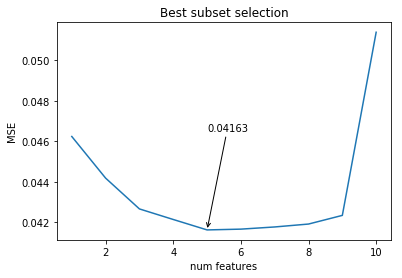

In [10]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
best_mse, best_features = best_subset_selection(X, y, LinearRegression())

In [11]:
# linear model with features from PCA analysis
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
model = LinearRegression()
pred = cross_val_predict(model, X[features_from_pca], y, cv=5)
mse = mean_squared_error(y, pred)
print('features from PCA:', features_from_pca)
print('mse using features from PCA:', mse)

features from PCA: ['african_american_p' 'white_p' 'total_expend']
mse using features from PCA: 0.0497624287928728


## Supervised Learning: Best Subset Selection + Linear Regression (Interpretation)

Analyze feature subset produced from previous step.

                            OLS Regression Results                            
Dep. Variable:                    ppi   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     55.36
Date:                Sun, 05 May 2019   Prob (F-statistic):           5.97e-62
Time:                        12:04:04   Log-Likelihood:                 281.43
No. Observations:                1518   AIC:                            -548.9
Df Residuals:                    1511   BIC:                            -511.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

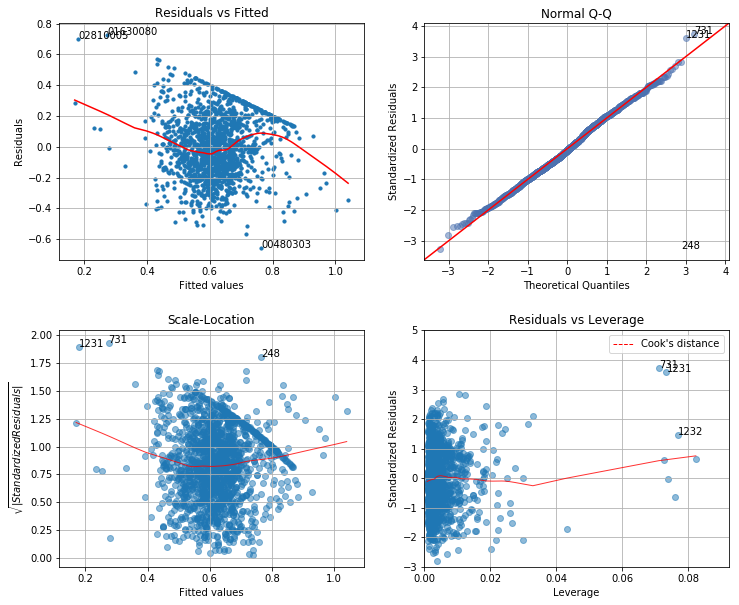

In [28]:
# interpretation of best subset for linear model
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
formula = 'ppi ~ {}'.format(' + '.join(best_features))
model = smf.ols(formula, df).fit()
diagnostic_plots(model, df)
pred = model.predict()
print(model.summary())

**Normal Q-Q:** residuals are normally distributed  
**Residuals vs Leverage:** all points appear to be within cooks distance

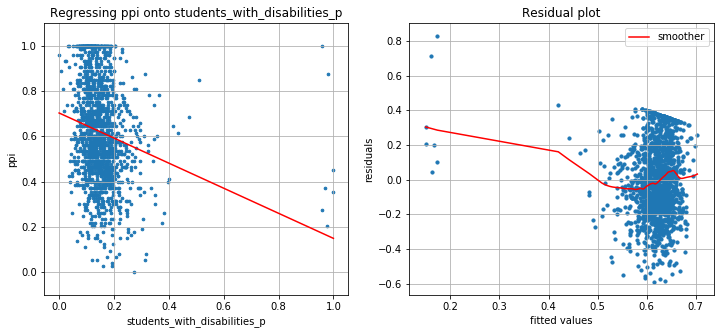

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppi   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     62.05
Date:                Sun, 05 May 2019   Prob (F-statistic):           6.35e-15
Time:                        12:23:34   Log-Likelihood:                 161.06
No. Observations:                1518   AIC:                            -318.1
Df Residuals:                    1516   BIC:                            -307.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.7031      0.012     58.539      0.000       0.680       0.727
students_with_disabilities_p    -0.5535      0.070     -7.877      0.000      -0.691      -0.416
==============================================================================
Omnibus:                       29.297   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.969
Skew:                           0.068   Prob(JB):                     0.000207
Kurtosis:                       2.500   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
model = smf.ols('ppi ~ students_with_disabilities_p', df).fit()
regression_plots_2d(model, df, 'students_with_disabilities_p', 'ppi', lambda x,a,b: a + b*x)
model.summary()

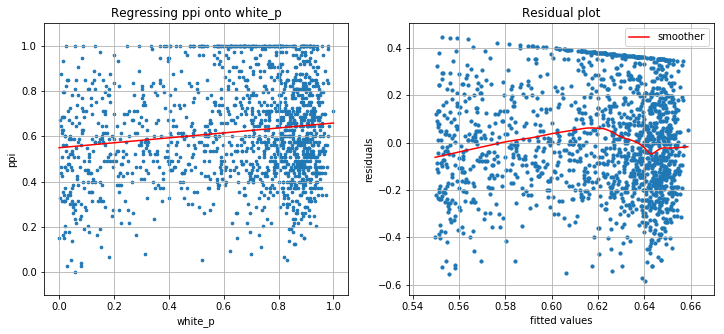

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppi   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     30.95
Date:                Sun, 05 May 2019   Prob (F-statistic):           3.13e-08
Time:                        09:36:33   Log-Likelihood:                 145.95
No. Observations:                1518   AIC:                            -287.9
Df Residuals:                    1516   BIC:                            -277.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5497      0.014     40.033      0.000       0.523       0.577
white_p        0.1091      0.020      5.563      0.000       0.071       0.148
==============================================================================
Omnibus:                       67.928   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.064
Skew:                           0.055   Prob(JB):                     4.88e-07
Kurtosis:                       2.331   Cond. No.                         4.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
model = smf.ols('ppi ~ white_p', df).fit()
regression_plots_2d(model, df, 'white_p', 'ppi', lambda x,a,b: a + b*x)
model.summary()

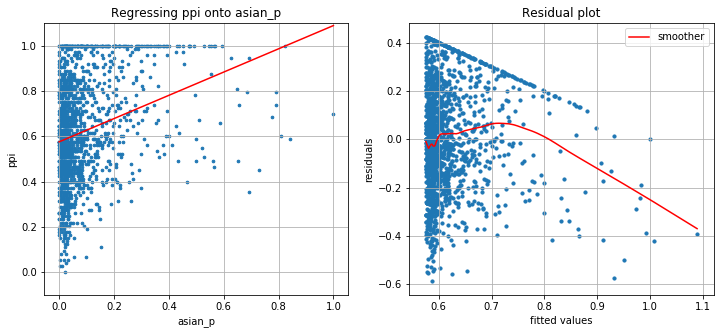

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppi   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     127.3
Date:                Sun, 05 May 2019   Prob (F-statistic):           2.13e-28
Time:                        12:17:26   Log-Likelihood:                 191.79
No. Observations:                1518   AIC:                            -379.6
Df Residuals:                    1516   BIC:                            -368.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5757      0.007     85.809      0.000       0.563       0.589
asian_p        0.5134      0.046     11.281      0.000       0.424       0.603
==============================================================================
Omnibus:                       47.234   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.607
Skew:                          -0.008   Prob(JB):                     1.23e-05
Kurtosis:                       2.402   Cond. No.                         8.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
model = smf.ols('ppi ~ asian_p', df).fit()
regression_plots_2d(model, df, 'asian_p', 'ppi', lambda x,a,b: a + b*x)
model.summary()

the model indicates a statistically significant slight positive correlation between the percent of white students and the ppi score of the school. however it's important to note the adjusted r-squared is 0.019 which indicates the model does a poor job overall of explaining the data. so very limited insight can be inferred from this.

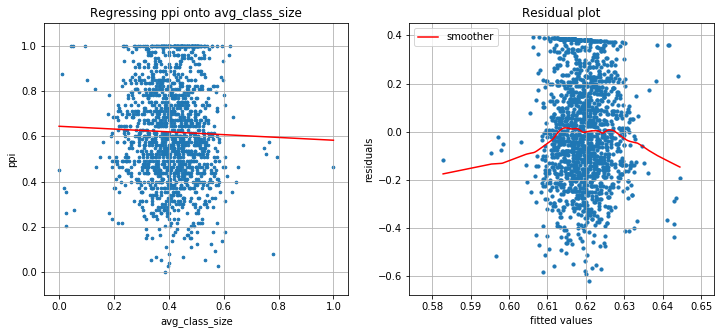

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppi   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.104
Date:                Sun, 05 May 2019   Prob (F-statistic):              0.293
Time:                        12:24:32   Log-Likelihood:                 131.17
No. Observations:                1518   AIC:                            -258.3
Df Residuals:                    1516   BIC:                            -247.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6444      0.025     26.266      0.000       0.596       0.693
avg_class_size    -0.0616      0.059     -1.051      0.293      -0.177       0.053
==============================================================================
Omnibus:                       56.399   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.672
Skew:                           0.042   Prob(JB):                     2.66e-06
Kurtosis:                       2.368   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
formula = 'ppi ~ avg_class_size'
model = smf.ols(formula, df).fit()
regression_plots_2d(model, df, 'avg_class_size', 'ppi', lambda x,a,b: a + b*x)
model.summary()

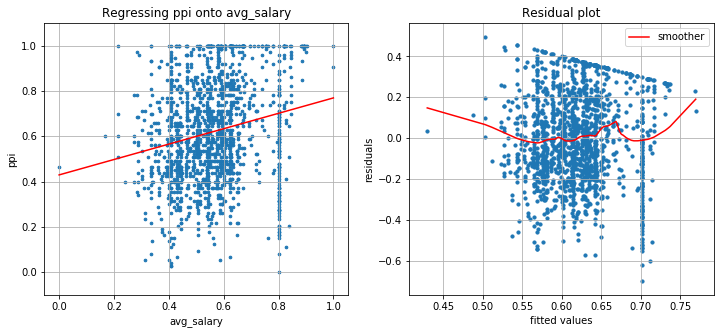

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppi   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     65.22
Date:                Sun, 05 May 2019   Prob (F-statistic):           1.35e-15
Time:                        09:36:33   Log-Likelihood:                 162.59
No. Observations:                1518   AIC:                            -321.2
Df Residuals:                    1516   BIC:                            -310.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4297      0.024     17.806      0.000       0.382       0.477
avg_salary     0.3400      0.042      8.076      0.000       0.257       0.423
==============================================================================
Omnibus:                       28.925   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.485
Skew:                          -0.049   Prob(JB):                     0.000263
Kurtosis:                       2.499   Cond. No.                         9.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)
formula = 'ppi ~ avg_salary'
model = smf.ols(formula, df).fit()
regression_plots_2d(model, df, 'avg_salary', 'ppi', lambda x,a,b: a + b*x)
model.summary()

the model indicates a statistically significant slight positive correlation between the average salary of school staff and the ppi score of the school. however it's important to note the adjusted r-squared is 0.041 (slightly better than the previous adjusted r-squared of 0.019) which indicates the model does a poor job overall of explaining the data. so very limited insight can be inferred from this.

## Supervised Learning: Best Subset Selection + Ridge Regression

Total elapsed time: 13.043653964996338 seconds.
Total elapsed time: 12.704497814178467 seconds.
Total elapsed time: 12.699357032775879 seconds.
Total elapsed time: 12.52739691734314 seconds.
Total elapsed time: 12.480530977249146 seconds.
Total elapsed time: 12.328210830688477 seconds.
Total elapsed time: 12.475682973861694 seconds.

Best feature subsets for each alpha
        mse  alpha                                      best_features
0  0.041631  0.001  [students_with_disabilities_p, asian_p, avg_cl...
1  0.041631  0.010  [students_with_disabilities_p, asian_p, avg_cl...
2  0.041629  0.100  [students_with_disabilities_p, asian_p, avg_cl...
3  0.041635  0.500  [students_with_disabilities_p, asian_p, avg_cl...
4  0.041664  1.000  [students_with_disabilities_p, asian_p, avg_cl...
5  0.041738  3.000  [students_with_disabilities_p, african_america...
6  0.041915  5.000  [students_with_disabilities_p, african_america...

best_alpha: 0.1
best_mse: 0.04162935040525199
best_features: ['stud

Text(0.1, 0.041772294572395896, '0.04163')

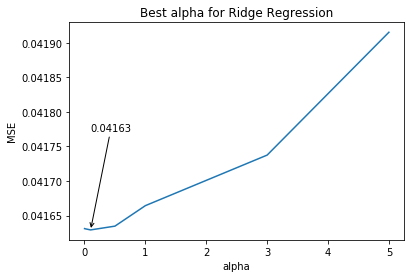

In [38]:
# best mse from best subset + linear regression:        0.041631
# we see slightly better cross validated average mse of 0.041629 with a Ridge model with alpha=0.1,
# but this model is less interprettable.
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)

rows = []
alphas = [0.001, 0.01, 0.1, 0.5, 1, 3, 5]
for alpha in alphas:
    best_mse, best_features = best_subset_selection(X, y, Ridge(alpha=alpha), True)
    rows.append([best_mse, alpha, best_features])

results_df = pd.DataFrame(rows, columns=['mse', 'alpha', 'best_features'])
print('\nBest feature subsets for each alpha')
print(results_df)

plt.plot(results_df.alpha.values, results_df.mse.values)
plt.title('Best alpha for Ridge Regression')
plt.ylabel('MSE')
plt.xlabel('alpha')
best_mse = results_df.mse.min()
worst_mse = results_df.mse.max()
best_alpha = results_df[results_df.mse == best_mse].alpha.values[0]
best_features = results_df[results_df.mse == best_mse].best_features.values[0]
print('\nbest_alpha:', best_alpha)
print('best_mse:', best_mse)
print('best_features:', best_features)
plt.annotate('%0.5f' % best_mse,
             xy=(best_alpha, best_mse),
             xytext=(best_alpha, (best_mse+worst_mse)/2),
             arrowprops=dict(arrowstyle="->"))

## Supervised Learning: Best Subset + Decision Tree

Total elapsed time: 14.962709188461304 seconds.
Total elapsed time: 15.934213876724243 seconds.
Total elapsed time: 18.264911890029907 seconds.
Total elapsed time: 19.7193820476532 seconds.
Total elapsed time: 21.59183430671692 seconds.
Total elapsed time: 22.89134979248047 seconds.
Total elapsed time: 23.906039714813232 seconds.

Best feature subsets for each depth
        mse  depth                                      best_features
0  0.044940      2  [african_american_p, asian_p, avg_expend_per_p...
1  0.043401      3  [students_with_disabilities_p, african_america...
2  0.043132      4  [african_american_p, asian_p, females_p, avg_c...
3  0.044101      5        [african_american_p, asian_p, num_students]
4  0.045144      6  [students_with_disabilities_p, african_america...
5  0.047418      7  [asian_p, white_p, females_p, num_students, av...
6  0.050121      8  [african_american_p, asian_p, white_p, females...

best_depth: 4
best_mse: 0.04313249354358892
best_features: ['african_a

Text(4, 0.04662670182066961, '0.04313')

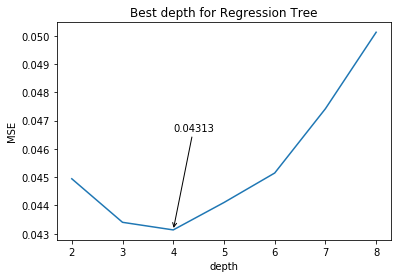

In [41]:
y = df.ppi
X = df.drop(columns=dependent_variables, axis=1)

rows = []
for depth in range(2,9):
    best_mse, best_features = best_subset_selection(X, y, tree.DecisionTreeRegressor(max_depth=depth), True)
    rows.append([best_mse, depth, best_features])
results_df = pd.DataFrame(rows, columns=['mse', 'depth', 'best_features'])

print('\nBest feature subsets for each depth')
print(results_df)

plt.plot(results_df.depth.values, results_df.mse.values)
plt.title('Best depth for Regression Tree')
plt.ylabel('MSE')
plt.xlabel('depth')
best_mse = results_df.mse.min()
worst_mse = results_df.mse.max()
best_depth = results_df[results_df.mse == best_mse].depth.values[0]
best_features = results_df[results_df.mse == best_mse].best_features.values[0]
print('\nbest_depth:', best_depth)
print('best_mse:', best_mse)
print('best_features:', best_features)
plt.annotate('%0.5f' % best_mse,
             xy=(best_depth, best_mse),
             xytext=(best_depth, (best_mse+worst_mse)/2),
             arrowprops=dict(arrowstyle="->"))

mse: 0.04046255572003989


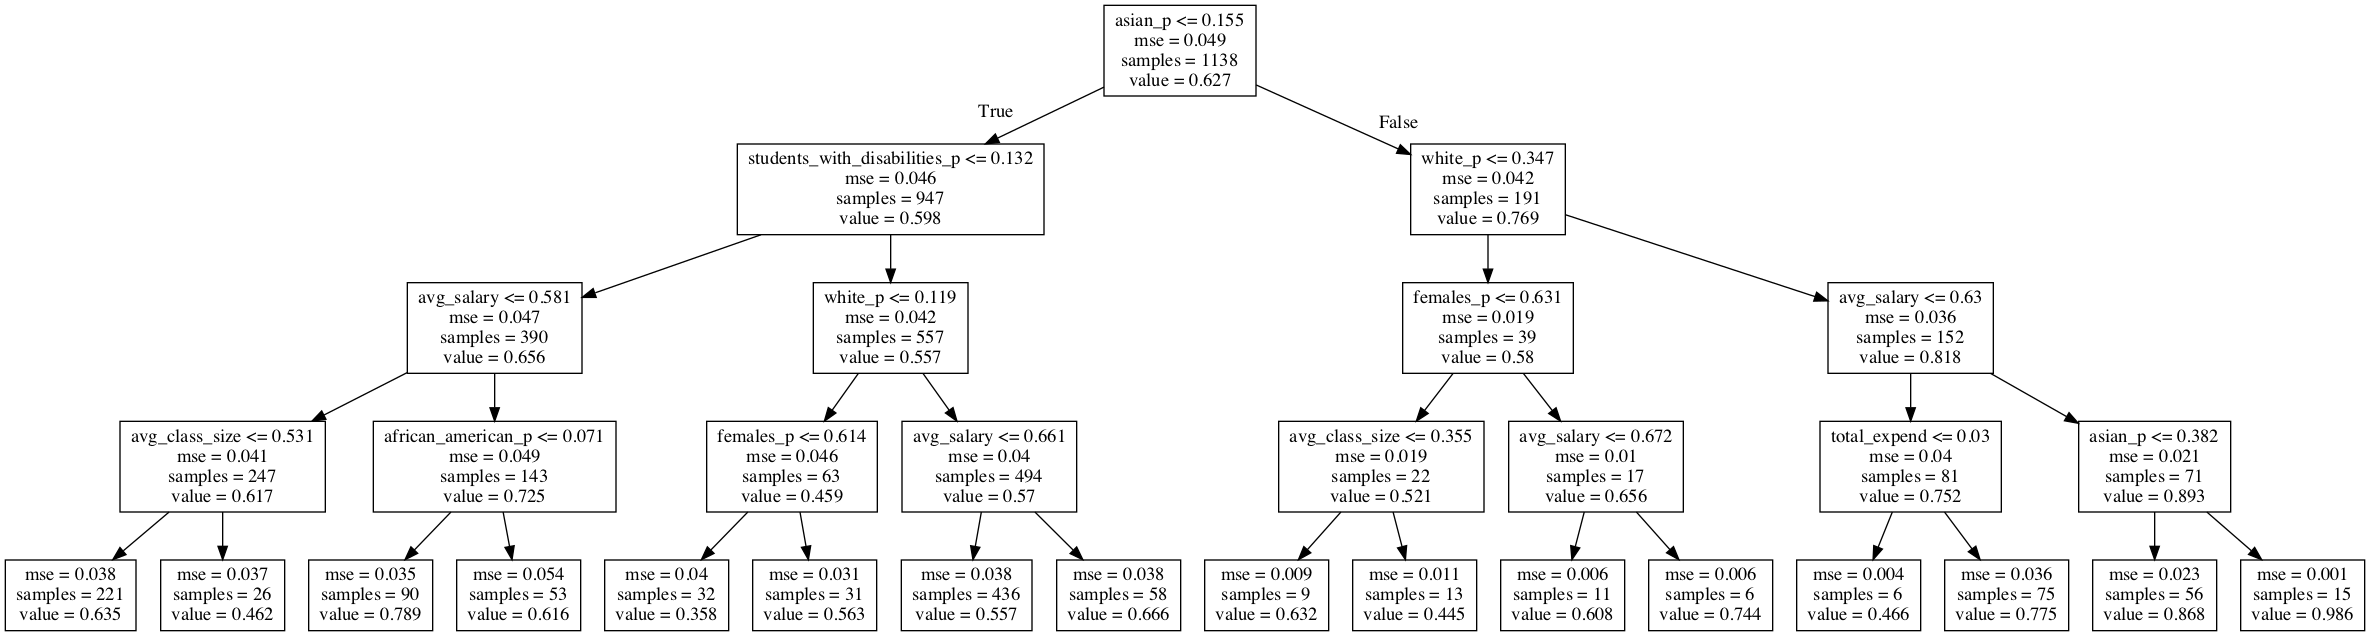

In [17]:
y = df.ppi
X = df[best_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = tree.DecisionTreeRegressor(max_depth=best_depth)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
print('mse:', mse)
output = print_tree(model, X_train.columns)
output

A tree based model could be improved with bagging or boosting but we'd lose some interpretability. If I had more time I would look into those options further. One insight is that highest ppi scores are associated with all of the following:
- higher percentages of white students
- higher average salaries
- higher percentages of asian students

## Supervised Learning (qualatative): Best Subset + LDA

Processed 10 models on 1 features in 0.19045305252075195 seconds.
Processed 45 models on 2 features in 0.9177322387695312 seconds.
Processed 120 models on 3 features in 2.315011739730835 seconds.
Processed 210 models on 4 features in 4.164718866348267 seconds.
Processed 252 models on 5 features in 5.082904100418091 seconds.
Processed 210 models on 6 features in 4.457823991775513 seconds.
Processed 120 models on 7 features in 2.5799567699432373 seconds.
Processed 45 models on 8 features in 0.9965651035308838 seconds.
Processed 10 models on 9 features in 0.22960615158081055 seconds.
Processed 1 models on 10 features in 0.025983095169067383 seconds.
Total elapsed time: 20.985919952392578 seconds.

Best models for each number of features:
       score                                        feature_set num_features
1   0.539514                                          [white_p]            1
2   0.566571                                 [asian_p, white_p]            2
3   0.566541            

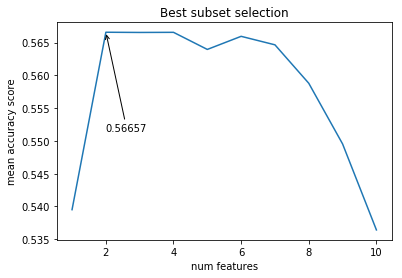

In [18]:
y = df.accountability_level
X = df.drop(columns=dependent_variables, axis=1)
model = LinearDiscriminantAnalysis()
best_mse, best_features = best_subset_selection(X, y, model, False, False)

## Supervised Learning (qualatative): Best Subset + QDA

Processed 10 models on 1 features in 0.16841793060302734 seconds.
Processed 45 models on 2 features in 0.7744011878967285 seconds.
Processed 120 models on 3 features in 2.099078893661499 seconds.
Processed 210 models on 4 features in 3.7474172115325928 seconds.
Processed 252 models on 5 features in 4.772191047668457 seconds.
Processed 210 models on 6 features in 4.507245063781738 seconds.
Processed 120 models on 7 features in 2.525552988052368 seconds.
Processed 45 models on 8 features in 0.9861299991607666 seconds.
Processed 10 models on 9 features in 0.19723010063171387 seconds.
Processed 1 models on 10 features in 0.021820068359375 seconds.
Total elapsed time: 19.824889183044434 seconds.

Best models for each number of features:
       score                                        feature_set num_features
1   0.538183                                          [white_p]            1
2   0.556110                                 [asian_p, white_p]            2
3   0.558055               

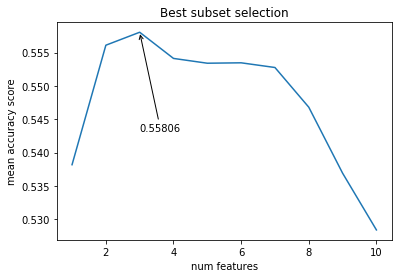

In [19]:
import warnings
warnings.filterwarnings('ignore')
y = df.accountability_level
X = df.drop(columns=dependent_variables, axis=1)
model = QuadraticDiscriminantAnalysis()
best_mse, best_features = best_subset_selection(X, y, model, False, False)

## Supervised Learning (qualatative): Best Subset + KNN

In [14]:
y = df.accountability_level
X = df.drop(columns=dependent_variables, axis=1)
rows = []
for n_neighbors in [1, 5, 15, 25, 37, 51, 75, 101, 151, 201, 251]:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    best_score, best_features = best_subset_selection(X, y, model, True, False)
    rows.append([best_score, n_neighbors, best_features])

results_df = pd.DataFrame(rows, columns=['score', 'n_neighbors', 'best_features'])
best_score = results_df.score.max()
worst_score = results_df.score.min()
best_n_neighbors = results_df[results_df.score == best_score].n_neighbors.values[0]
best_features = results_df[results_df.score == best_score].best_features.values[0]

Total elapsed time: 53.83689022064209 seconds.
Total elapsed time: 58.56866407394409 seconds.
Total elapsed time: 63.02621388435364 seconds.
Total elapsed time: 65.90365409851074 seconds.
Total elapsed time: 69.73274183273315 seconds.
Total elapsed time: 74.03163313865662 seconds.
Total elapsed time: 80.59769320487976 seconds.
Total elapsed time: 86.76978087425232 seconds.
Total elapsed time: 99.92777800559998 seconds.
Total elapsed time: 112.90877389907837 seconds.
Total elapsed time: 123.9641363620758 seconds.


In [15]:
print('\nBest feature subsets for each n_neighbors')
print(results_df)
print('\nbest_n_neighbors:', best_n_neighbors)
print('best_score:', best_score)
print('\nbest features:', best_features)


Best feature subsets for each n_neighbors
       score  n_neighbors                                      best_features
0   0.477067            1  [students_with_disabilities_p, african_america...
1   0.514472            5  [students_with_disabilities_p, african_america...
2   0.554731           15  [asian_p, white_p, females_p, avg_class_size, ...
3   0.567301           25  [students_with_disabilities_p, asian_p, white_...
4   0.578451           37  [students_with_disabilities_p, african_america...
5   0.582422           51  [students_with_disabilities_p, african_america...
6   0.577111           75  [african_american_p, asian_p, white_p, females...
7   0.575758          101                     [asian_p, white_p, avg_salary]
8   0.576457          151  [african_american_p, asian_p, white_p, females_p]
9   0.574457          201  [african_american_p, asian_p, white_p, avg_cla...
10  0.565209          251  [students_with_disabilities_p, asian_p, white_...

best_n_neighbors: 51
best_score:

Text(51, 0.5297443184174924, '0.5824219849804023')

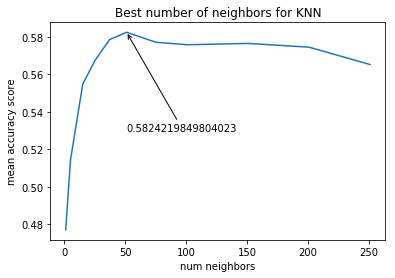

In [16]:
plt.plot(results_df.n_neighbors.values, results_df.score.values)
plt.title('Best number of neighbors for KNN')
plt.ylabel('mean accuracy score')
plt.xlabel('num neighbors')
plt.annotate(best_score,
             xy=(best_n_neighbors, best_score),
             xytext=(best_n_neighbors, (best_score+worst_score)/2),
             arrowprops=dict(arrowstyle='->'))

In [1]:
print('done')

done
